<a href="https://colab.research.google.com/github/dev-rkoshlyak/mlinseconds_solutions/blob/helloxor_day1/HelloXor_Day_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load codebase

In [0]:
!git clone https://github.com/dev-rkoshlyak/mlinseconds_solutions.git

Cloning into 'mlinseconds_solutions'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 191 (delta 89), reused 190 (delta 88), pack-reused 0
Receiving objects: 100% (191/191), 56.98 KiB | 2.37 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [0]:
%cd mlinseconds_solutions/

/content/mlinseconds_solutions


In [0]:
!git checkout -b helloxor_day1

Switched to a new branch 'helloxor_day1'


# Edit code

In [0]:
%%writefile mlis/problems/helloXor.py
# HelloXor is a HelloWorld of Machine Learning.
import time
import random
import argparse
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ..utils import solutionmanager as sm
from ..utils import gridsearch as gs

class SolutionModel(nn.Module):
    def __init__(self, input_size, output_size, solution):
        super(SolutionModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = solution.hidden_size
        self.linear1 = nn.Linear(input_size, self.hidden_size)
        self.linear2 = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        return x

    def calc_error(self, output, target):
        # This is loss function
        return ((output-target)**2).sum()

    def calc_predict(self, output):
        # Simple round output to predict value
        return output.round()

class Solution():
    def __init__(self):
        # Control speed of learning
        self.learning_rate = 0.00001
        # Control number of hidden neurons
        self.hidden_size = 1
        # Maximum number of steps
        self.max_steps = 100
        # grid search will initialize this field
        self.grid_search = None
        # grid search will initialize this field
        self.iter = 0

    # Return trained model
    def train_model(self, train_data, train_target, context):
        # Model represent our neural network
        model = SolutionModel(train_data.size(1), train_target.size(1), self)
        # Optimizer used for training neural network
        optimizer = optim.SGD(model.parameters(), lr=self.learning_rate)
        step_till_correct = self.max_steps
        while True:
            # Report step, so we know how many steps
            context.increase_step()
            # model.parameters()...gradient set to zero
            optimizer.zero_grad()
            # evaluate model => model.forward(data)
            output = model(train_data)
            # if x < 0.5 predict 0 else predict 1
            predict = model.calc_predict(output)
            # Number of correct predictions
            correct = predict.eq(train_target.view_as(predict)).long().sum().item()
            # Total number of needed predictions
            total = predict.view(-1).size(0)
            # No more time left or learned everything, stop training
            time_left = context.get_timer().get_time_left()
            if total == correct:
                step_till_correct = min(step_till_correct, context.step)
            if context.step == self.max_steps:
                break
            # calculate error
            error = model.calc_error(output, train_target)
            # calculate deriviative of model.forward() and put it in model.parameters()...gradient
            error.backward()
            # print progress of the learning
            #self.print_stats(context.step, error, correct, total)
            # update model: model.parameters() -= lr * gradient
            optimizer.step()

        if self.grid_search:
            self.grid_search.add_result('error', error.item())
            self.grid_search.add_result('step', step_till_correct)
            if self.iter == self.iter_number-1:
                if self.iter == self.iter_number-1:
                    stats_error = self.grid_search.get_stats('error')
                    stats_step = self.grid_search.get_stats('step')
                    print('{} => Error {} {} Step {} {}'.format(self.grid_search.choice_str, *stats_error, *stats_step))
        return model

    def print_stats(self, step, error, correct, total):
        if step % 1000 == 0:
            print("Step = {} Correct = {}/{} Error = {}".format(step, correct, total, error.item()))

###
###
### Don't change code after this line
###
###
class Limits:
    def __init__(self):
        self.time_limit = 2.0
        self.size_limit = 100
        self.test_limit = 1.0

class DataProvider:
    def __init__(self):
        self.number_of_cases = 10

    def create_data(self):
        data = torch.FloatTensor([
            [0.0, 0.0],
            [0.0, 1.0],
            [1.0, 0.0],
            [1.0, 1.0]
            ])
        target = torch.FloatTensor([
            [0.0],
            [1.0],
            [1.0],
            [0.0]
            ])
        return (data, target)

    def create_case_data(self, case):
        data, target = self.create_data()
        return sm.CaseData(case, Limits(), (data, target), (data, target))

class Config:
    def __init__(self):
        self.max_samples = 10000

    def get_data_provider(self):
        return DataProvider()

    def get_solution(self):
        return Solution()

run_grid_search = False
# Uncomment next line if you want to run grid search
run_grid_search = True
if run_grid_search:
    parser = argparse.ArgumentParser(description='Grid search', allow_abbrev=False)
    parser.add_argument('-iter_number', type=int, default=10)
    parser.add_argument('-max_steps', type=int, nargs='+', default=[100])
    parser.add_argument('-hidden_size', type=int, nargs='+', default=[1])
    parser.add_argument('-learning_rate', type=float, nargs='+', default=[1.0])
    results_file = 'helloxor_day1_results_data.pickle'
    results_data = gs.ResultsData.load(results_file)
    gs.GridSearch().run(Config(), case_number=1, results_data=results_data, grid_parser=parser)
    results_data.save(results_file)
else:
    # If you want to run specific case, put number here
    sm.SolutionManager().run(Config(), case_number=-1)

Overwriting mlis/problems/helloXor.py


# Review code

In [0]:
!git diff

diff --git a/mlis/problems/helloXor.py b/mlis/problems/helloXor.py
index 94113ab..a65993a 100644
--- a/mlis/problems/helloXor.py
+++ b/mlis/problems/helloXor.py
@@ -1,6 +1,7 @@
 # HelloXor is a HelloWorld of Machine Learning.
 import time
 import random
+import argparse
 import torch
 import torchvision
 import torch.nn as nn
@@ -13,7 +14,6 @@ class SolutionModel(nn.Module):
     def __init__(self, input_size, output_size, solution):
         super(SolutionModel, self).__init__()
         self.input_size = input_size
-        sm.SolutionManager.print_hint("Hint[1]: Increase hidden size")
         self.hidden_size = solution.hidden_size
         self.linear1 = nn.Linear(input_size, self.hidden_size)
         self.linear2 = nn.Linear(self.hidden_size, output_size)
@@ -39,26 +39,20 @@ class Solution():
         self.learning_rate = 0.00001
         # Control number of hidden neurons
         self.hidden_size = 1
-
-        # Grid search settings, see grid_search_tutorial
-        self.lea

# Run code

In [0]:
!python3 -m mlis.problems.helloXor -max_steps 1000 -hidden_size 2 3 4 5 6 -learning_rate 0.001 0.01 0.1 1.0 10.0 -iter_number 10

[WARNING] file with data not exists, return empty results data
Local CPU time mult = 0.37
max_steps:1000 hidden_size:2 learning_rate:0.001 => Error 1.0098284482955933 0.011905469000339508 Step 1000.0 0.0
max_steps:1000 hidden_size:2 learning_rate:0.01 => Error 1.0004913806915283 0.0011279662139713764 Step 1000.0 0.0
max_steps:1000 hidden_size:2 learning_rate:0.1 => Error 0.9887807965278625 0.022199122235178947 Step 1000.0 0.0
max_steps:1000 hidden_size:2 learning_rate:1.0 => Error 0.1983834058046341 0.24816502630710602 Step 676.7000122070312 303.7663879394531
max_steps:1000 hidden_size:2 learning_rate:10.0 => Error 0.33653688430786133 0.44663098454475403 Step 361.70001220703125 369.7840270996094
max_steps:1000 hidden_size:3 learning_rate:0.001 => Error 1.0049002170562744 0.0063309259712696075 Step 1000.0 0.0
max_steps:1000 hidden_size:3 learning_rate:0.01 => Error 0.9995249509811401 0.0012808036990463734 Step 1000.0 0.0
max_steps:1000 hidden_size:3 learning_rate:0.1 => Error 0.97203224

# Data exploration

Let's print first 5 rows of data from gridsearch to see overall structure

In [0]:
from mlis.utils import gridsearch as gs
from mlis.utils import plotter as pt
import matplotlib.pyplot as plt
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
df = results_data.get_dataframe()
df.head()

,max_steps,hidden_size,learning_rate,type,value
0,1000,2,0.001,error,1.003844
1,1000,2,0.001,error,1.004815
2,1000,2,0.001,error,1.002031
3,1000,2,0.001,error,1.013707
4,1000,2,0.001,error,1.027174


Let's see minimum, maximum, mean and std of value grouped by type and hidden_size

In [0]:
df.groupby(['type', 'hidden_size']).agg({'value':['count', 'min', 'mean', 'max', 'std']})

value                                                
                  count        min        mean          max         std
type  hidden_size                                                      
error 2              50   0.000169    0.706804     1.034395    0.425874
      3              50   0.000170    0.647646     1.017348    0.471793
      4              50   0.000172    0.616192     1.017682    0.485998
      5              50   0.000207    0.596469     1.006481    0.490596
      6              50   0.000197    0.591206     1.006492    0.487982
step  2              50  85.000000  807.680000  1000.000000  329.850828
      3              50  71.000000  706.220000  1000.000000  388.005380
      4              50  60.000000  691.640000  1000.000000  394.056339
      5              50  66.000000  668.860000  1000.000000  413.989254
      6              50  61.000000  668.840000  1000.000000  414.854553

Now grouped by learning_rate.

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
df = results_data.get_dataframe()
df.groupby(['type', 'learning_rate']).agg({'value':['count', 'min', 'mean', 'max', 'std']})

value                                                   
                    count          min         mean          max         std
type  learning_rate                                                         
error 0.001            50     0.998479     1.005252     1.034395    0.007428
      0.010            50     0.995363     0.999889     1.002720    0.001320
      0.100            50     0.706445     0.971451     1.000176    0.052756
      1.000            50     0.002279     0.042887     0.505087    0.132215
      10.000           50     0.000169     0.138837     0.999510    0.328160
step  0.001            50  1000.000000  1000.000000  1000.000000    0.000000
      0.010            50  1000.000000  1000.000000  1000.000000    0.000000
      0.100            50  1000.000000  1000.000000  1000.000000    0.000000
      1.000            50   106.000000   348.460000  1000.000000  232.838756
      10.000           50    60.000000   194.780000  1000.000000  236.138345

We don't see clear pattern when groupped by hidden_size
But we can see clear pattern when groupped by learning_rate
Look like learning_rate 1.0 and 10.0 works much better then smaller ones
If we will look at error metric we wil see that it much mor sensative.
For example, we can see that 0.01 works better then 0.001, in case of step we see 1000 there

Why it behave this way?
The bigger learning rate we get, the bigger improvements we can make during each step. We will need to try bigger learning rate 100.0

In [0]:
!python3 -m mlis.problems.helloXor -max_steps 1000 -hidden_size 2 3 4 5 6 -learning_rate 100.0 -iter_number 10

Local CPU time mult = 0.64
max_steps:1000 hidden_size:2 learning_rate:100.0 => Error 2.0 8.04601398840532e-08 Step 1000.0 0.0
max_steps:1000 hidden_size:3 learning_rate:100.0 => Error 2.0 3.0157829655763635e-07 Step 1000.0 0.0
max_steps:1000 hidden_size:4 learning_rate:100.0 => Error 1.999982476234436 5.562464502872899e-05 Step 1000.0 0.0
max_steps:1000 hidden_size:5 learning_rate:100.0 => Error 1.9999996423721313 1.1239861805734108e-06 Step 1000.0 0.0
max_steps:1000 hidden_size:6 learning_rate:100.0 => Error 2.0 3.7697287069704544e-08 Step 1000.0 0.0
[SEARCH COMPLETED]
Specify case_number, if you want to search over other case data


Let's look at error value for now.
Note: wee need to reload data since we run grid search one more time

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
df = results_data.get_dataframe()
df.query('type == "error"').groupby(['type', 'learning_rate']).agg({'value':['count', 'min', 'mean', 'max', 'std']})

value                                        
                    count       min      mean       max       std
type  learning_rate                                              
error 0.001            50  0.998479  1.005252  1.034395  0.007428
      0.010            50  0.995363  0.999889  1.002720  0.001320
      0.100            50  0.706445  0.971451  1.000176  0.052756
      1.000            50  0.002279  0.042887  0.505087  0.132215
      10.000           50  0.000169  0.138837  0.999510  0.328160
      100.000          50  1.999824  1.999996  2.000000  0.000025

We would like to add more data points for learning rate, but let's choose only one hidden size, for this we will see hidden_size wch produce minimum error

In [0]:
df = results_data.get_dataframe()
df.loc[df.query('type == "error"').groupby(['type', 'learning_rate']).value.idxmin()]

,max_steps,hidden_size,learning_rate,type,value
105,1000,3,0.001,error,0.998479
425,1000,6,0.010,error,0.995363
445,1000,6,0.100,error,0.706445
365,1000,5,1.000,error,0.002279
84,1000,2,10.000,error,0.000169
547,1000,4,100.000,error,1.999824


It's not clear which one is better, but let's go with 5, since it show good results learning rates 1.0 and 10.0

In [0]:
!python3 -m mlis.problems.helloXor -max_steps 1000 -hidden_size 5 -learning_rate {1..20} -iter_number 10

Local CPU time mult = 0.62
max_steps:1000 hidden_size:5 learning_rate:1.0 => Error 0.003546519670635462 0.0007825731881894171 Step 234.3000030517578 91.18639373779297
max_steps:1000 hidden_size:5 learning_rate:2.0 => Error 0.0012887469492852688 0.00017130804189946502 Step 117.4000015258789 29.519107818603516
max_steps:1000 hidden_size:5 learning_rate:3.0 => Error 0.0008759360061958432 0.00011297986202407628 Step 81.80000305175781 15.998611450195312
max_steps:1000 hidden_size:5 learning_rate:4.0 => Error 0.0006988652748987079 7.31500331312418e-05 Step 91.80000305175781 43.003360748291016
max_steps:1000 hidden_size:5 learning_rate:5.0 => Error 0.0005529996706172824 5.4090662160888314e-05 Step 87.9000015258789 19.87991714477539
max_steps:1000 hidden_size:5 learning_rate:6.0 => Error 0.0004590859171003103 4.4954933400731534e-05 Step 96.69999694824219 35.62786102294922
max_steps:1000 hidden_size:5 learning_rate:7.0 => Error 0.0003642096125986427 6.071778625482693e-05 Step 89.69999694824219 

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
df = results_data.get_dataframe()
df.query('type == "error" and hidden_size == 5').groupby(['type', 'learning_rate']).agg({'value':['count', 'min', 'mean', 'max', 'std']})

value                                        
                    count       min      mean       max       std
type  learning_rate                                              
error 0.001            10  1.000129  1.002184  1.006481  0.002313
      0.010            10  0.998318  0.999858  1.001170  0.000794
      0.100            10  0.921049  0.976423  0.999592  0.028241
      1.000            20  0.002279  0.003547  0.005596  0.000783
      2.000            10  0.001064  0.001289  0.001599  0.000171
      3.000            10  0.000593  0.000876  0.000977  0.000113
      4.000            10  0.000620  0.000699  0.000890  0.000073
      5.000            10  0.000442  0.000553  0.000621  0.000054
      6.000            10  0.000410  0.000459  0.000546  0.000045
      7.000            10  0.000251  0.000364  0.000439  0.000061
      8.000            10  0.000222  0.000325  0.000415  0.000055
      9.000            10  0.000199  0.000264  0.000309  0.000035
      10.000           20  0.000151  0.049432  0.983978  0.219969
      11.000           10  0.000197  0.199404  0.998941  0.419898
      12.000           10  0.000153  0.100173  0.999919  0.316139
      13.000           10  0.000179  0.499933  0.999841  0.526762
      14.000           10  0.000141  0.382179  0.999906  0.495838
      15.000           10  0.000121  0.185807  0.970366  0.391814
      16.000           10  0.000088  0.368937  0.999996  0.484002
      17.000           10  0.000129  0.965055  1.999992  0.822089
      18.000           10  0.000099  1.179197  2.000006  0.797313
      19.000           10  0.000017  0.983418  2.000018  0.818036
      20.000           10  0.530504  1.298177  2.000000  0.626834
      100.000          10  1.999996  2.000000  2.000000  0.000001

Let's show graph to better understand data

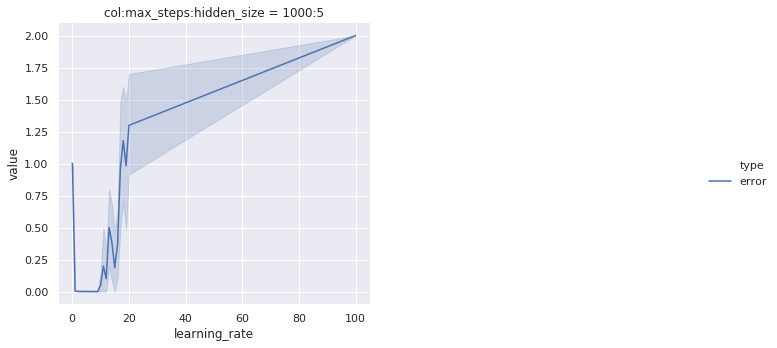

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and hidden_size in [5]")
#plt.show() # Not needed for jupyter

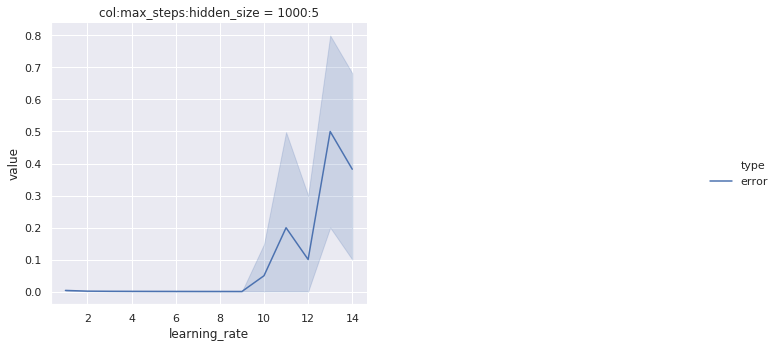

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and hidden_size in [5] and 0.5 <= learning_rate and learning_rate < 15.0")
#plt.show() # Not needed for jupyter

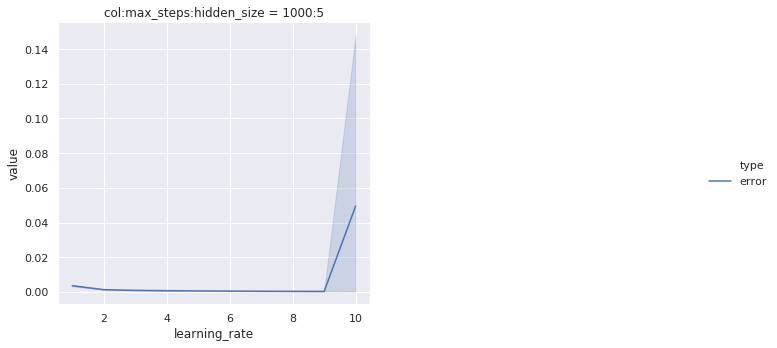

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and hidden_size in [5] and 1.0 <= learning_rate and learning_rate <= 10.0")
#plt.show() # Not needed for jupyter

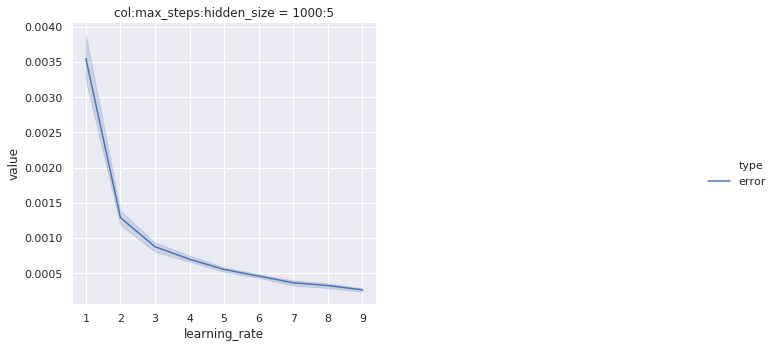

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and hidden_size in [5] and 1.0 <= learning_rate and learning_rate <= 9.0")
#plt.show() # Not needed for jupyter

Look like we need more points between 9.0 and 10.0 so, we can get optimal results

In [0]:
!python3 -m mlis.problems.helloXor -max_steps 1000 -hidden_size 5 -learning_rate `seq 9.0 0.1 10.0` -iter_number 10

Local CPU time mult = 0.64
max_steps:1000 hidden_size:5 learning_rate:9.0 => Error 0.0002709497348405421 4.340253144619055e-05 Step 82.5999984741211 20.959609985351562
max_steps:1000 hidden_size:5 learning_rate:9.1 => Error 0.00027353328187018633 4.418272874318063e-05 Step 96.0 46.125431060791016
max_steps:1000 hidden_size:5 learning_rate:9.2 => Error 0.00025743150035850704 5.643397889798507e-05 Step 94.0999984741211 41.64786148071289
max_steps:1000 hidden_size:5 learning_rate:9.3 => Error 0.00028614833718165755 6.581260095117614e-05 Step 86.4000015258789 24.663063049316406
max_steps:1000 hidden_size:5 learning_rate:9.4 => Error 0.0002694206195883453 3.808141627814621e-05 Step 98.0 33.8427734375
max_steps:1000 hidden_size:5 learning_rate:9.5 => Error 0.09961432963609695 0.3141844868659973 Step 103.5999984741211 56.57875442504883
max_steps:1000 hidden_size:5 learning_rate:9.6 => Error 0.0002554582606535405 6.219099304871634e-05 Step 99.80000305175781 60.550804138183594
max_steps:1000 hi

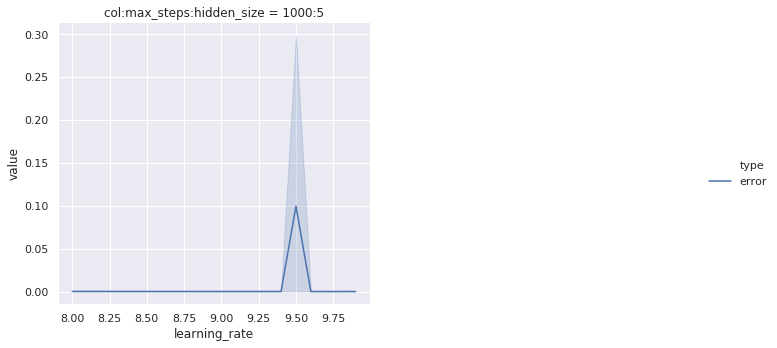

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and hidden_size in [5] and 8.0 <= learning_rate and learning_rate <= 9.9")
#plt.show() # Not needed for jupyter

At this point, we need more data points, to decrease confidence level, let's run 100 iterations

In [0]:
!python3 -m mlis.problems.helloXor -max_steps 1000 -hidden_size 5 -learning_rate `seq 9.0 0.1 10.0` -iter_number 100

Local CPU time mult = 0.60
max_steps:1000 hidden_size:5 learning_rate:9.0 => Error 0.013132931664586067 0.10340985655784607 Step 99.98332977294922 93.13060760498047
max_steps:1000 hidden_size:5 learning_rate:9.1 => Error 0.005248278379440308 0.05212877318263054 Step 98.04545593261719 90.50159454345703
max_steps:1000 hidden_size:5 learning_rate:9.2 => Error 0.0052797538228333 0.05248333513736725 Step 100.81818389892578 91.75737762451172
max_steps:1000 hidden_size:5 learning_rate:9.3 => Error 0.012644796632230282 0.09282177686691284 Step 106.47272491455078 97.47855377197266
max_steps:1000 hidden_size:5 learning_rate:9.4 => Error 0.014339628629386425 0.1076977550983429 Step 111.51818084716797 117.49555969238281
max_steps:1000 hidden_size:5 learning_rate:9.5 => Error 0.01442867610603571 0.10836023837327957 Step 115.45454406738281 137.2737579345703
max_steps:1000 hidden_size:5 learning_rate:9.6 => Error 0.014494973234832287 0.1089673563838005 Step 118.20909118652344 118.63482666015625
max_s

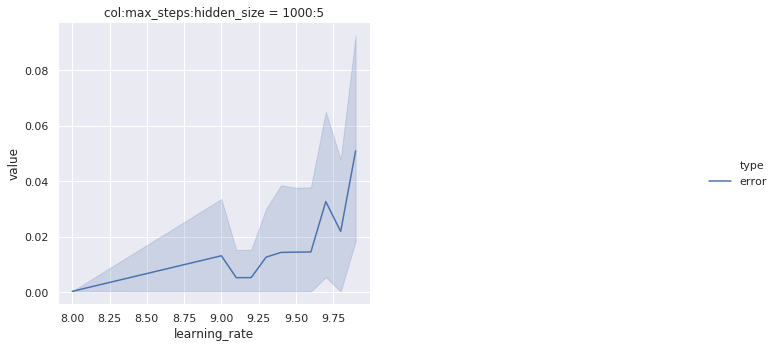

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and hidden_size in [5] and 8.0 <= learning_rate and learning_rate <= 9.9")
#plt.show() # Not needed for jupyter

Last run took a long time, let's change max_steps. Let's look on distribution of steps till all correct to get better max_steps limit

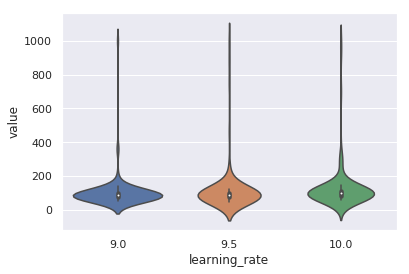

In [0]:
import seaborn as sns
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
df = results_data.get_dataframe()
steps_till_correct = df.query("type=='step' and hidden_size in [5] and learning_rate in [9.0, 9.5, 10.0]")
sns.violinplot(x="learning_rate", y="value", data=steps_till_correct)


We can go with 200 since most of runs finished before that, or even with 100 if we fine with 50% of finished only

In [0]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate `seq 9.0 0.1 10.0` -iter_number 1000

Local CPU time mult = 0.67
max_steps:100 hidden_size:5 learning_rate:9.0 => Error 0.4019738435745239 0.3981187045574188 Step 82.97200012207031 14.291096687316895
max_steps:100 hidden_size:5 learning_rate:9.1 => Error 0.40070053935050964 0.382273405790329 Step 83.99400329589844 14.552998542785645
max_steps:100 hidden_size:5 learning_rate:9.2 => Error 0.44223853945732117 0.4009929895401001 Step 84.81099700927734 14.105326652526855
max_steps:100 hidden_size:5 learning_rate:9.3 => Error 0.44410207867622375 0.40202152729034424 Step 85.75199890136719 13.68494701385498
max_steps:100 hidden_size:5 learning_rate:9.4 => Error 0.44497665762901306 0.3856836259365082 Step 85.98899841308594 14.082300186157227
max_steps:100 hidden_size:5 learning_rate:9.5 => Error 0.44559723138809204 0.39006924629211426 Step 85.9010009765625 14.14111614227295
max_steps:100 hidden_size:5 learning_rate:9.6 => Error 0.4568052291870117 0.395831435918808 Step 86.44599914550781 14.170034408569336
max_steps:100 hidden_size:

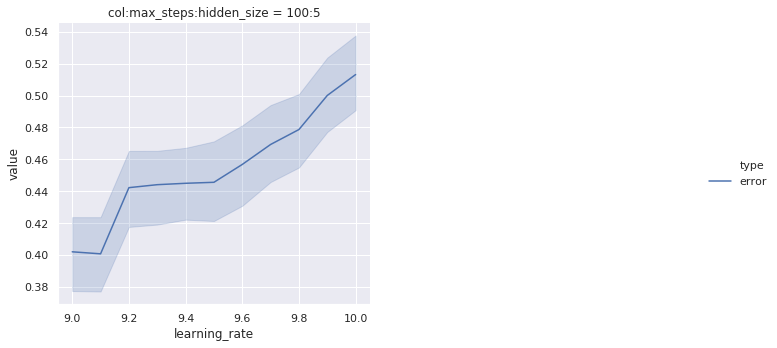

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps == 100 and hidden_size in [5]")
#plt.show() # Not needed for jupyter

It's taking too much time, may be we should give up on finding exact minimum, and say that around 9.0 is good for error metric. But look like, it totally changed for max_steps 100, let's look before 9.0

In [27]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate `seq 7.0 0.1 9.0` -iter_number 100

Local CPU time mult = 0.62
max_steps:100 hidden_size:5 learning_rate:7.0 => Error 0.42754101753234863 0.3230326771736145 Step 87.33499908447266 12.277887344360352
max_steps:100 hidden_size:5 learning_rate:7.1 => Error 0.4135311543941498 0.3194810748100281 Step 87.20500183105469 11.83823013305664
max_steps:100 hidden_size:5 learning_rate:7.2 => Error 0.4287208914756775 0.34463903307914734 Step 86.8550033569336 11.992626190185547
max_steps:100 hidden_size:5 learning_rate:7.3 => Error 0.389779269695282 0.3195982277393341 Step 86.62000274658203 12.014463424682617
max_steps:100 hidden_size:5 learning_rate:7.4 => Error 0.42203381657600403 0.3266143500804901 Step 86.74500274658203 12.421814918518066
max_steps:100 hidden_size:5 learning_rate:7.5 => Error 0.4392085671424866 0.3540591299533844 Step 86.77999877929688 12.477984428405762
max_steps:100 hidden_size:5 learning_rate:7.6 => Error 0.4195747375488281 0.331024706363678 Step 87.05500030517578 12.571883201599121
max_steps:100 hidden_size:5 l

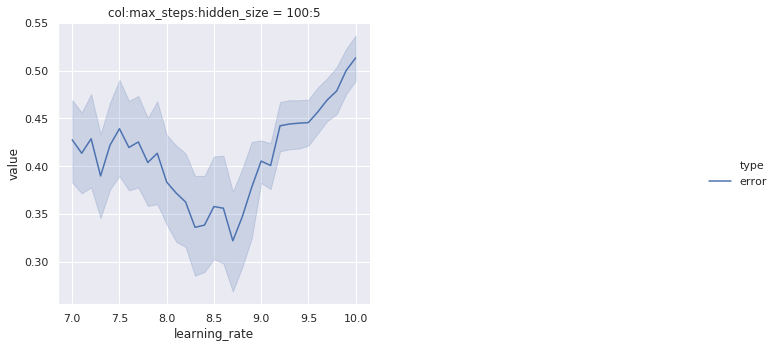

In [28]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps == 100 and hidden_size in [5]")
#plt.show() # Not needed for jupyter

Look like best would be around 8.5, let's confirm that point only

In [29]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate 8.5 -iter_number 1000

Local CPU time mult = 0.69
max_steps:100 hidden_size:5 learning_rate:8.5 => Error 0.35296255350112915 0.3686251938343048 Step 81.3066635131836 14.318757057189941
[SEARCH COMPLETED]
Specify case_number, if you want to search over other case data


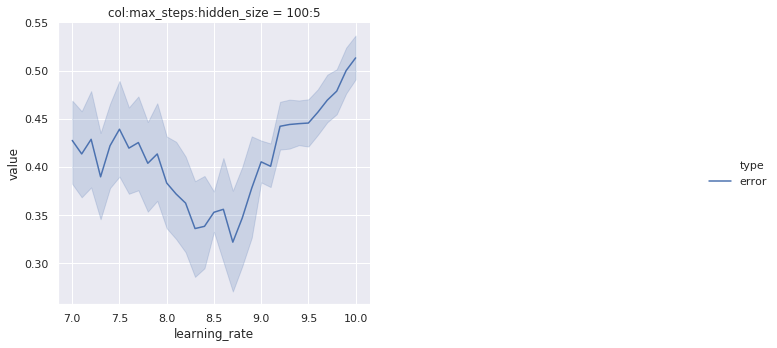

In [30]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps == 100 and hidden_size in [5]")
#plt.show() # Not needed for jupyter

Let's compare this data with max_steps 1000, to see if it look similar

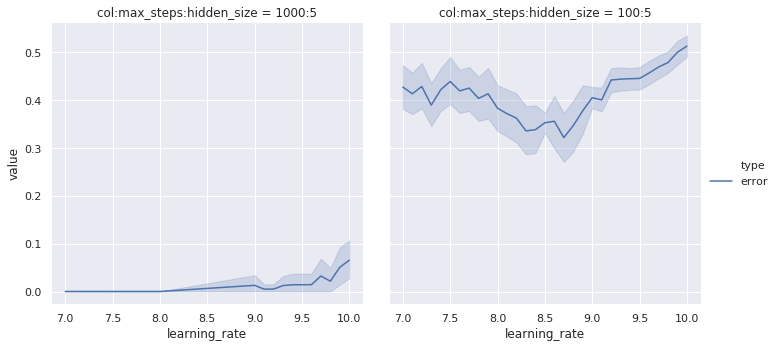

In [31]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100, 1000] and hidden_size in [5] and 7.0 <= learning_rate and learning_rate <= 10.0")
#plt.show() # Not needed for jupyter

It's not clear, if it corellate, but let's concentrate on understanding max_step 100. Let's confirm poing 7.0 and move on to looking into step metric

In [32]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate 7.0 -iter_number 1000

Local CPU time mult = 0.69
max_steps:100 hidden_size:5 learning_rate:7.0 => Error 0.43388742208480835 0.3227677345275879 Step 87.62000274658203 12.502433776855469
[SEARCH COMPLETED]
Specify case_number, if you want to search over other case data


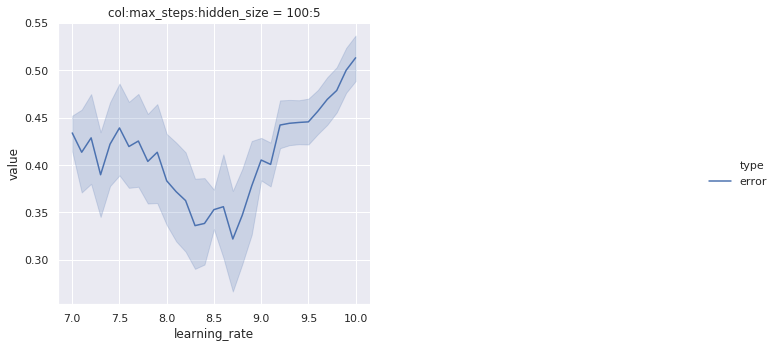

In [33]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100] and hidden_size in [5]")
#plt.show() # Not needed for jupyter

So we can clearly see that 8.5 better then 7.0 and 10.0, so let's look at our step statistic

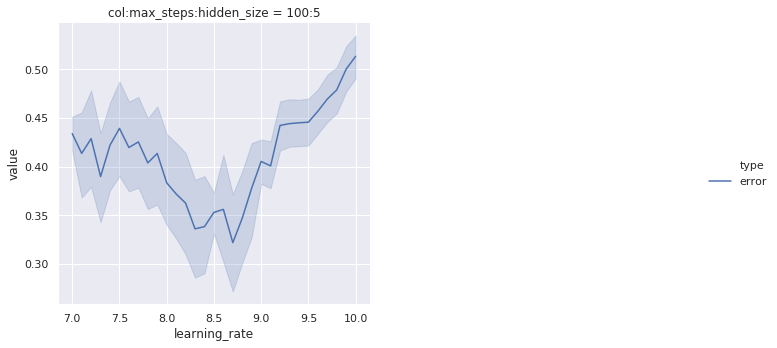

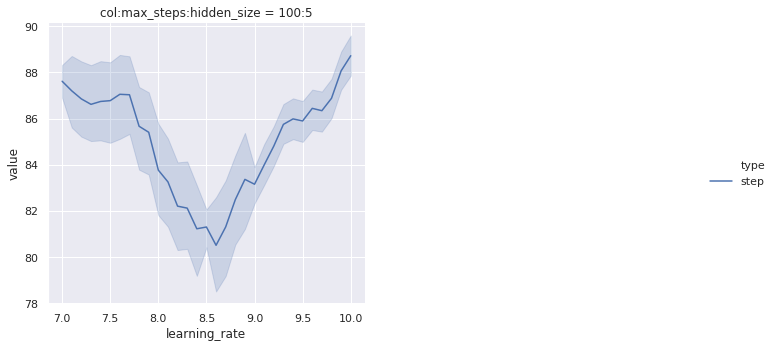

In [34]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100] and hidden_size in [5]")
plotter.show_1d(-1, query="type=='step' and max_steps in [100] and hidden_size in [5]")
#plt.show() # Not needed for jupyter

just to be sure, let's run small number of iterations for bigger range

In [35]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate `seq 1.0 0.1 20.0` -iter_number 10

Local CPU time mult = 0.67
max_steps:100 hidden_size:5 learning_rate:1.0 => Error 0.9793576002120972 0.02439275197684765 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.1 => Error 0.9683628082275391 0.037770383059978485 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.2 => Error 0.9527867436408997 0.05630593001842499 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.3 => Error 0.9319157600402832 0.08003174513578415 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.4 => Error 0.9054712057113647 0.10793774574995041 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.5 => Error 0.8991219401359558 0.09701669216156006 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.6 => Error 0.8723636865615845 0.1178603246808052 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.7 => Error 0.8611465692520142 0.13716121017932892 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:1.8 => Error 0.8221759796142578 0.1814415156841278 Step 99.

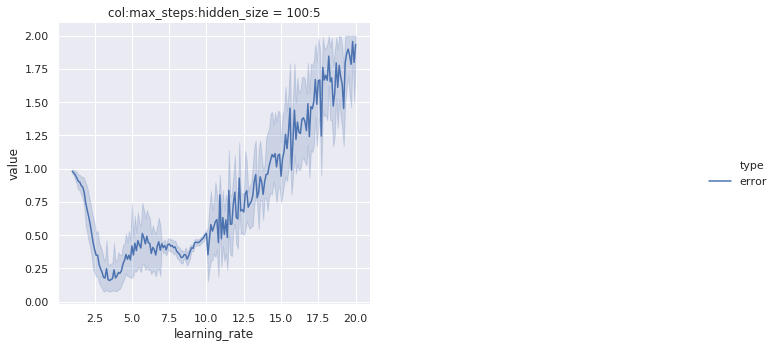

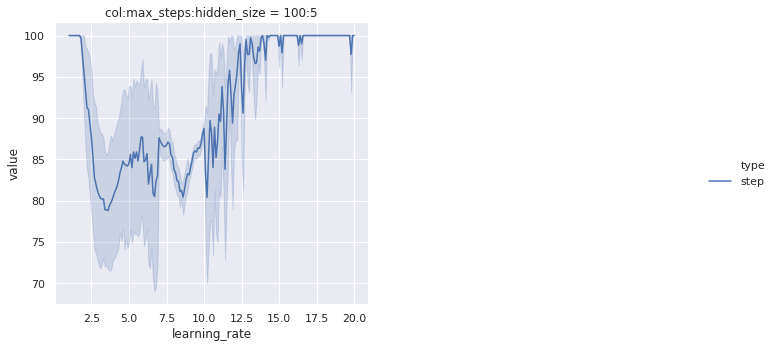

In [36]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100] and hidden_size in [5]")
plotter.show_1d(-1, query="type=='step' and max_steps in [100] and hidden_size in [5]")
#plt.show() # Not needed for jupyter

Wow, that's an surprise, let's confirm point 3.5

In [37]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate 3.5 -iter_number 1000

Local CPU time mult = 0.70
max_steps:100 hidden_size:5 learning_rate:3.5 => Error 0.22335787117481232 0.22704017162322998 Step 80.43366241455078 12.66336441040039
[SEARCH COMPLETED]
Specify case_number, if you want to search over other case data


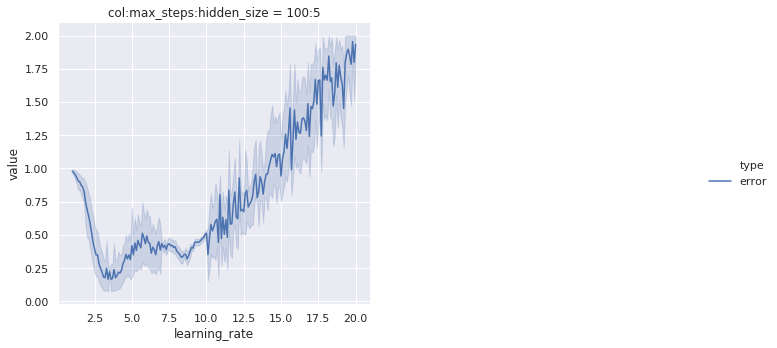

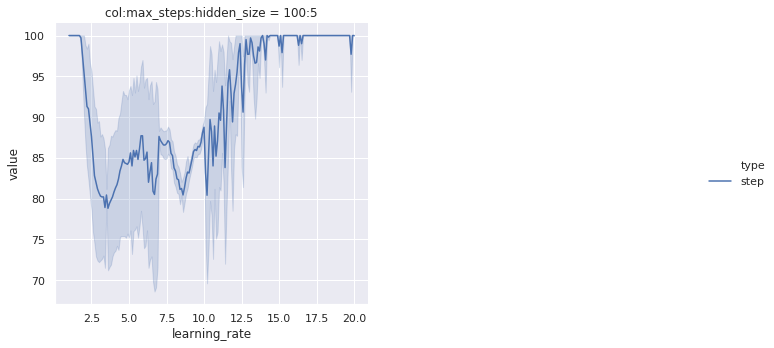

In [38]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100] and hidden_size in [5]")
plotter.show_1d(-1, query="type=='step' and max_steps in [100] and hidden_size in [5]")
#plt.show() # Not needed for jupyter

That's not what we expected, look like our graph will have more then 1 minimum, let's run with 100 iters between 2.5 and 7.0, while it will be running let's try to understand what's going on

In [39]:
!python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate `seq 2.5 0.1 7.0` -iter_number 100

Local CPU time mult = 0.71
max_steps:100 hidden_size:5 learning_rate:2.5 => Error 0.4071372151374817 0.24252372980117798 Step 88.61817932128906 11.585329055786133
max_steps:100 hidden_size:5 learning_rate:2.6 => Error 0.35257431864738464 0.23291157186031342 Step 86.5 11.704895973205566
max_steps:100 hidden_size:5 learning_rate:2.7 => Error 0.3185996115207672 0.2400067150592804 Step 84.5999984741211 11.402719497680664
max_steps:100 hidden_size:5 learning_rate:2.8 => Error 0.27753108739852905 0.22583629190921783 Step 82.89090728759766 11.329384803771973
max_steps:100 hidden_size:5 learning_rate:2.9 => Error 0.2636926472187042 0.23266614973545074 Step 81.63636016845703 11.277750968933105
max_steps:100 hidden_size:5 learning_rate:3.0 => Error 0.23373943567276 0.2057516723871231 Step 80.97272491455078 11.532529830932617
max_steps:100 hidden_size:5 learning_rate:3.1 => Error 0.21117468178272247 0.19178487360477448 Step 80.34545135498047 11.592813491821289
max_steps:100 hidden_size:5 learning

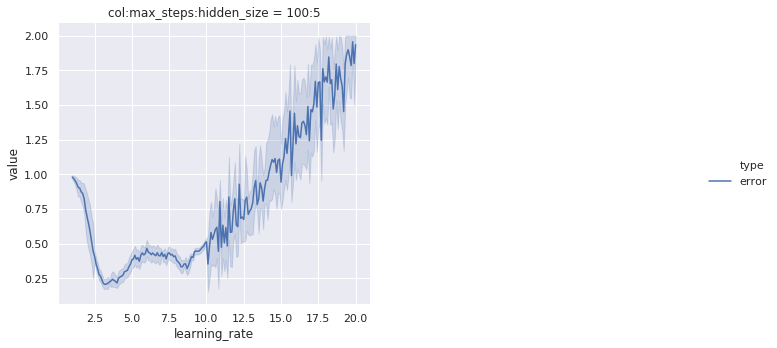

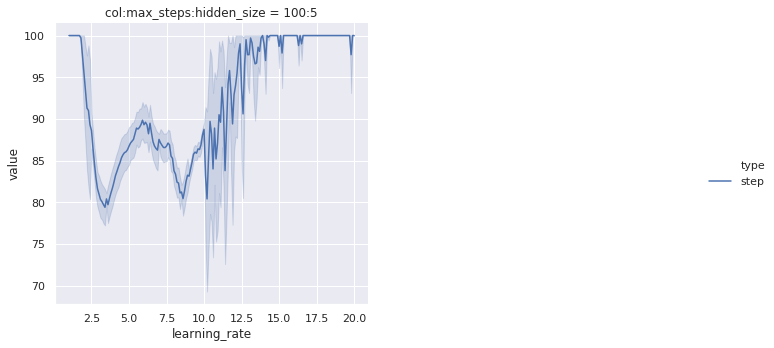

In [40]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100] and hidden_size in [5]")
plotter.show_1d(-1, query="type=='step' and max_steps in [100] and hidden_size in [5]")
#plt.show() # Not needed for jupyter

If there would be only one minimum in graph, we would explain it, that with small learning rate we need a lot of steps to get to minimum, but once learning rate increases we getting less and less steps needed, but at some points learning rate became to big and we start overshooting. Since we see 2 clear minimum we need to explain it differently. Also minimums on steps metrics visible more clear then on error metric. Let's start with looking at distribution in local minimums

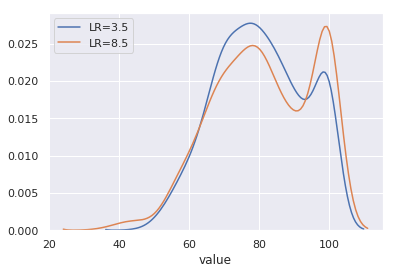

In [41]:
import seaborn as sns
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
df = results_data.get_dataframe()
filt = "type=='step' and max_steps == 100 and hidden_size in [5]"
steps_till_correct = df.query(filt)
sns.distplot(steps_till_correct.query('learning_rate == 3.5')['value'], hist=False, label='LR=3.5')
sns.distplot(steps_till_correct.query('learning_rate == 8.5')['value'], hist=False, label='LR=8.5')

It's not quite clear what happening, but let's finish up for a day and continue tomorrow

# Commit our work
Make sure you specify your email and user and your token and your origin if you want to save to your repo

In [0]:
!git branch
!git status

In [0]:
#!git config --global user.email "rkoshlyak@gmail.com"
#!git config --global user.name "Roman Koshlyak"
#!git add --all
#!git commit -m "HelloXor day1"

In [0]:
#!git remote rm origin
#!git remote add origin https://ff63244429dfc031ebf9577b71bd9f118d8979ca@github.com/dev-rkoshlyak/mlinseconds_solutions.git
#!git push origin helloxor_day1

# Work log
1. We create grid search with maximum number of steps, learning rate, and hidden size
2. We logged error and number of steps till all target correctly predicted
3. We find out that error metric much more sensative and good approximation for number of steps
4. We find out that we can decrease number of steps for speed up once we got initial approximation
5. We found 2 local minimum for learning rate 3.5 and 8.5
6. For now we can explain 2 local minimum by ratio between lucky runs and unlucky runs


# Long run

In [0]:
!time python3 -m mlis.problems.helloXor -max_steps 100 -hidden_size 5 -learning_rate `seq 0.0 0.1 20.0` -iter_number 1000

Local CPU time mult = 0.69
max_steps:100 hidden_size:5 learning_rate:0.0 => Error 1.034919261932373 0.0435388907790184 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:0.1 => Error 0.999815821647644 0.0012841267744079232 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:0.2 => Error 0.9993206858634949 0.0015542410546913743 Step 100.0 0.0
max_steps:100 hidden_size:5 learning_rate:0.3 => Error 0.9987538456916809 0.0021224396768957376 Step 99.99400329589844 0.18973666429519653
max_steps:100 hidden_size:5 learning_rate:0.4 => Error 0.9980251789093018 0.003098218934610486 Step 99.94599914550781 1.2101852893829346
max_steps:100 hidden_size:5 learning_rate:0.5 => Error 0.9970049262046814 0.004714326933026314 Step 99.95700073242188 1.3597793579101562
max_steps:100 hidden_size:5 learning_rate:0.6 => Error 0.9954953789710999 0.007352969143539667 Step 99.94300079345703 1.6475634574890137
max_steps:100 hidden_size:5 learning_rate:0.7 => Error 0.9931963682174683 0.0115809366106987 St

In [0]:
results_data = gs.ResultsData.load('helloxor_day1_results_data.pickle')
plotter = pt.Plotter(results_data)
plotter.show_1d(-1, query="type=='error' and max_steps in [100] and hidden_size in [5] and 0.0 <= learning_rate and learning_rate <= 20.0")
plotter.show_1d(-1, query="type=='step'and max_steps in [100] and hidden_size in [5] and 0.0 <= learning_rate and learning_rate <= 20.0")
plotter.show_1d(-1, query="type=='error' and max_steps in [1000] and hidden_size in [5] and 0.0 <= learning_rate and learning_rate <= 20.0")
plotter.show_1d(-1, query="type=='step' and max_steps in [1000] and hidden_size in [5] and 0.0 <= learning_rate and learning_rate <= 20.0")